###**Ambil Pustaka**

In [10]:
import subprocess
import sys

packages = ['sastrawi', 'wordcloud']
for pkg in packages:
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

In [11]:
import datetime as dt
import re
import string
import json
import csv
from io import StringIO

import pandas as pd
import numpy as np
import requests

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory as IDStemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

pd.options.mode.chained_assignment = None

RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### **Collecting Data**

###**Cleaning data**

In [12]:
review_app_df = pd.read_csv('https://raw.githubusercontent.com/rokhudev/Analisis_Sentimen_MCGG/731b2eac19a8c57d042e84f2cd3943f4ea28d326/ulasan_mcgg.csv')
review_app_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52576 entries, 0 to 52575
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              52576 non-null  object
 1   userName              52576 non-null  object
 2   userImage             52576 non-null  object
 3   content               52576 non-null  object
 4   score                 52576 non-null  int64 
 5   thumbsUpCount         52576 non-null  int64 
 6   reviewCreatedVersion  37895 non-null  object
 7   at                    52576 non-null  object
 8   replyContent          1 non-null      object
 9   repliedAt             1 non-null      object
 10  appVersion            37895 non-null  object
dtypes: int64(2), object(9)
memory usage: 4.4+ MB


In [13]:
unused_head = ['reviewId',
               'userName',
               'userImage',
               'score',
               'thumbsUpCount',
               'reviewCreatedVersion',
               'at',
               'replyContent',
               'repliedAt',
               'appVersion']

# Menghapus semua kolom yang tidak digunakan
review_app_df.drop(columns=unused_head, inplace=True)

review_app_df.head()

,content
0,setelah reset season terlalu sulit mendapatkan...
1,"Honestly, nih game cocok banget buat para play..."
2,"untuk segi gameplay,gw lebih suka yang sekaran..."
3,"pada update 26 mei 2025, V.1.1.85.1742 terdapa..."
4,walau terlihat player lain melakukan kecuranga...


In [14]:
clean_df = review_app_df.dropna()
clean_df.drop_duplicates().reset_index(drop=True)
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52576 entries, 0 to 52575
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  52576 non-null  object
dtypes: object(1)
memory usage: 410.9+ KB


In [15]:
# Inisialisasi Lemmatizer
wnl = WordNetLemmatizer()

# siapkan stopword
stopword_factory = StopWordRemoverFactory()
stopword_list = set(stopword_factory.get_stop_words())

# siapkan kamus slang
get_slangs = requests.get('https://raw.githubusercontent.com/louisowen6/NLP_bahasa_resources/refs/heads/master/combined_slang_words.txt')
if get_slangs.status_code == 200:
    slang_dict_raw = json.loads(get_slangs.text)
    slangwords = {key.lower(): value for key, value in slang_dict_raw.items()}
else:
    print("Gagal Ambil Data Slang")
    slangwords = {}

In [16]:
def cleaningText(text):
    # Gabungkan pola
    combined_pattern = re.compile(r'@[A-Za-z0-9]+|#[A-Za-z0-9]+|RT[\s]|https?:\S+|[0-9]+')
    text = combined_pattern.sub('', text)

    # hapus tanda baca, baris baru, dan spasi berlebih
    text = text.replace('\n', ' ')
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

def casefoldingText(text):
    return text.lower()

def tokenizingText(text):
    return word_tokenize(text)

def filteringText(text):
    return [word for word in text if word not in stopword_list]

def lemmatingText(text):
    words = text.split()
    lemmatized_words = [wnl.lemmatize(word, pos="v") for word in words]
    return ' '.join(lemmatized_words)

def fix_slangwords(text):
    return ' '.join([slangwords.get(word, word) for word in text.split()])

def toSentence(list_words):
    return ' '.join(list_words)

In [17]:
# buat satu fungsi utama
def full_processing_pipeline(text):
    text_clean = cleaningText(text)
    text_casefolding = casefoldingText(text_clean)
    text_slang = fix_slangwords(text_casefolding)
    text_lemmatized = lemmatingText(text_slang)
    text_tokenized = tokenizingText(text_lemmatized)
    text_stopwords = filteringText(text_tokenized)
    text_final = toSentence(text_stopwords)

    # kembalikan tuple/list
    return [text_clean, text_casefolding, text_slang, text_lemmatized,
            text_tokenized, text_stopwords, text_final]

results = clean_df['content'].apply(full_processing_pipeline)

# buat semua kolom baru
clean_df[[
    'text_clean',
    'text_casefoldingText',
    'text_slangwords',
    'text_lemmatized',
    'text_tokenizingText',
    'text_stopword',
    'text_akhir'
]] = pd.DataFrame(results.tolist(), index=clean_df.index)

In [18]:
clean_df

,content,text_clean,text_casefoldingText,text_slangwords,text_lemmatized,text_tokenizingText,text_stopword,text_akhir
0,setelah reset season terlalu sulit mendapatkan...,setelah reset season terlalu sulit mendapatkan...,setelah reset season terlalu sulit mendapatkan...,setelah reset season terlalu sulit mendapatkan...,setelah reset season terlalu sulit mendapatkan...,"[setelah, reset, season, terlalu, sulit, menda...","[reset, season, terlalu, sulit, mendapatkan, k...",reset season terlalu sulit mendapatkan kemenan...
1,"Honestly, nih game cocok banget buat para play...",Honestly nih game cocok banget buat para playe...,honestly nih game cocok banget buat para playe...,honestly ini game cocok banget buat para playe...,honestly ini game cocok banget buat para playe...,"[honestly, ini, game, cocok, banget, buat, par...","[honestly, game, cocok, banget, buat, player, ...",honestly game cocok banget buat player ml stre...
2,"untuk segi gameplay,gw lebih suka yang sekaran...",untuk segi gameplaygw lebih suka yang sekarang...,untuk segi gameplaygw lebih suka yang sekarang...,untuk segi gameplaygw lebih suka yang sekarang...,untuk segi gameplaygw lebih suka yang sekarang...,"[untuk, segi, gameplaygw, lebih, suka, yang, s...","[segi, gameplaygw, lebih, suka, sekarang, diba...",segi gameplaygw lebih suka sekarang dibanding ...
3,"pada update 26 mei 2025, V.1.1.85.1742 terdapa...",pada update mei V terdapat masalah pada KONE...,pada update mei v terdapat masalah pada kone...,pada update mei v terdapat masalah pada koneks...,pada update mei v terdapat masalah pada koneks...,"[pada, update, mei, v, terdapat, masalah, pada...","[update, mei, v, terdapat, masalah, koneksi, m...",update mei v terdapat masalah koneksi mcgg dul...
4,walau terlihat player lain melakukan kecuranga...,walau terlihat player lain melakukan kecuranga...,walau terlihat player lain melakukan kecuranga...,walau terlihat player lain melakukan kecuranga...,walau terlihat player lie melakukan kecurangan...,"[walau, terlihat, player, lie, melakukan, kecu...","[terlihat, player, lie, melakukan, kecurangan,...",terlihat player lie melakukan kecurangan perna...
...,...,...,...,...,...,...,...,...
52571,👎,,,,,[],[],
52572,👎,,,,,[],[],
52573,🤬,,,,,[],[],
52574,Nice ⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️,Nice,nice,nice,nice,[nice],[nice],nice


In [19]:
clean_df.tail(200)

,content,text_clean,text_casefoldingText,text_slangwords,text_lemmatized,text_tokenizingText,text_stopword,text_akhir
52376,Good game,Good game,good game,good game,good game,"[good, game]","[good, game]",good game
52377,Bagus bingit,Bagus bingit,bagus bingit,bagus bingit,bagus bingit,"[bagus, bingit]","[bagus, bingit]",bagus bingit
52378,cukup bagus,cukup bagus,cukup bagus,cukup bagus,cukup bagus,"[cukup, bagus]","[cukup, bagus]",cukup bagus
52379,Nice games,Nice games,nice games,nice games,nice game,"[nice, game]","[nice, game]",nice game
52380,mantap oi,mantap oi,mantap oi,mantap oi,mantap oi,"[mantap, oi]","[mantap, oi]",mantap oi
...,...,...,...,...,...,...,...,...
52571,👎,,,,,[],[],
52572,👎,,,,,[],[],
52573,🤬,,,,,[],[],
52574,Nice ⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️,Nice,nice,nice,nice,[nice],[nice],nice


In [20]:
clean_df.dropna()
ready_df = clean_df.drop(clean_df.tail(200).index)

###**Labelling**

####**Labelling dengan Lexicon Indonesia**

In [21]:
# unduh dan proses file lexicon dari URL
def unduh_dan_proses_lexicon(url: str) -> dict:
    """
    Mengunduh file CSV dari URL, memprosesnya, dan mengembalikannya sebagai kamus.
    Mengembalikan kamus kosong jika terjadi kesalahan.
    """
    try:
        response = requests.get(url)
        response.raise_for_status()

        # dictionary comprehension
        reader = csv.reader(StringIO(response.text), delimiter=',')
        lexicon_dict = {row[0]: int(row[1]) for row in reader}
        return lexicon_dict

    except requests.exceptions.RequestException as e:
        print(f"Gagal mengunduh data dari {url}: {e}")
    except (ValueError, IndexError) as e:
        print(f"Gagal memproses data dari {url}, periksa format file: {e}")

    return {}

url_positive = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv'
url_negative = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv'

lexicon_positive = unduh_dan_proses_lexicon(url_positive)
lexicon_negative = unduh_dan_proses_lexicon(url_negative)

if not lexicon_positive:
    print("Variabel lexicon_positive kosong karena terjadi kesalahan saat pengambilan data.")

if not lexicon_negative:
    print("Variabel lexicon_negative kosong karena terjadi kesalahan saat pengambilan data.")

In [22]:
def sentiment_analysis_lexicon_indonesia(text):

    # hitung skor dalam satu perulangan menggunakan 'sum' dan generator expression.
    score = sum(lexicon_positive.get(word, 0) + lexicon_negative.get(word, 0) for word in text)

    # tentukan polaritas skor akhir
    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

In [23]:
ready_df['label_score'], ready_df['label'] = zip(*ready_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia))

In [24]:
print(ready_df['label'].value_counts())

label
negative    23782
positive    17503
neutral     11091
Name: count, dtype: int64


In [25]:
ready_df

,content,text_clean,text_casefoldingText,text_slangwords,text_lemmatized,text_tokenizingText,text_stopword,text_akhir,label_score,label
0,setelah reset season terlalu sulit mendapatkan...,setelah reset season terlalu sulit mendapatkan...,setelah reset season terlalu sulit mendapatkan...,setelah reset season terlalu sulit mendapatkan...,setelah reset season terlalu sulit mendapatkan...,"[setelah, reset, season, terlalu, sulit, menda...","[reset, season, terlalu, sulit, mendapatkan, k...",reset season terlalu sulit mendapatkan kemenan...,-28,negative
1,"Honestly, nih game cocok banget buat para play...",Honestly nih game cocok banget buat para playe...,honestly nih game cocok banget buat para playe...,honestly ini game cocok banget buat para playe...,honestly ini game cocok banget buat para playe...,"[honestly, ini, game, cocok, banget, buat, par...","[honestly, game, cocok, banget, buat, player, ...",honestly game cocok banget buat player ml stre...,16,positive
2,"untuk segi gameplay,gw lebih suka yang sekaran...",untuk segi gameplaygw lebih suka yang sekarang...,untuk segi gameplaygw lebih suka yang sekarang...,untuk segi gameplaygw lebih suka yang sekarang...,untuk segi gameplaygw lebih suka yang sekarang...,"[untuk, segi, gameplaygw, lebih, suka, yang, s...","[segi, gameplaygw, lebih, suka, sekarang, diba...",segi gameplaygw lebih suka sekarang dibanding ...,-7,negative
3,"pada update 26 mei 2025, V.1.1.85.1742 terdapa...",pada update mei V terdapat masalah pada KONE...,pada update mei v terdapat masalah pada kone...,pada update mei v terdapat masalah pada koneks...,pada update mei v terdapat masalah pada koneks...,"[pada, update, mei, v, terdapat, masalah, pada...","[update, mei, v, terdapat, masalah, koneksi, m...",update mei v terdapat masalah koneksi mcgg dul...,-9,negative
4,walau terlihat player lain melakukan kecuranga...,walau terlihat player lain melakukan kecuranga...,walau terlihat player lain melakukan kecuranga...,walau terlihat player lain melakukan kecuranga...,walau terlihat player lie melakukan kecurangan...,"[walau, terlihat, player, lie, melakukan, kecu...","[terlihat, player, lie, melakukan, kecurangan,...",terlihat player lie melakukan kecurangan perna...,-12,negative
...,...,...,...,...,...,...,...,...,...,...
52371,seru banget,seru banget,seru banget,seru banget,seru banget,"[seru, banget]","[seru, banget]",seru banget,1,positive
52372,Sangat bagus,Sangat bagus,sangat bagus,sangat bagus,sangat bagus,"[sangat, bagus]","[sangat, bagus]",sangat bagus,-4,negative
52373,GG si ini,GG si ini,gg si ini,gg si ini,gg si ini,"[gg, si, ini]","[gg, si]",gg si,0,neutral
52374,Good games,Good games,good games,good games,good game,"[good, game]","[good, game]",good game,7,positive


###**Eksplorasi Data**

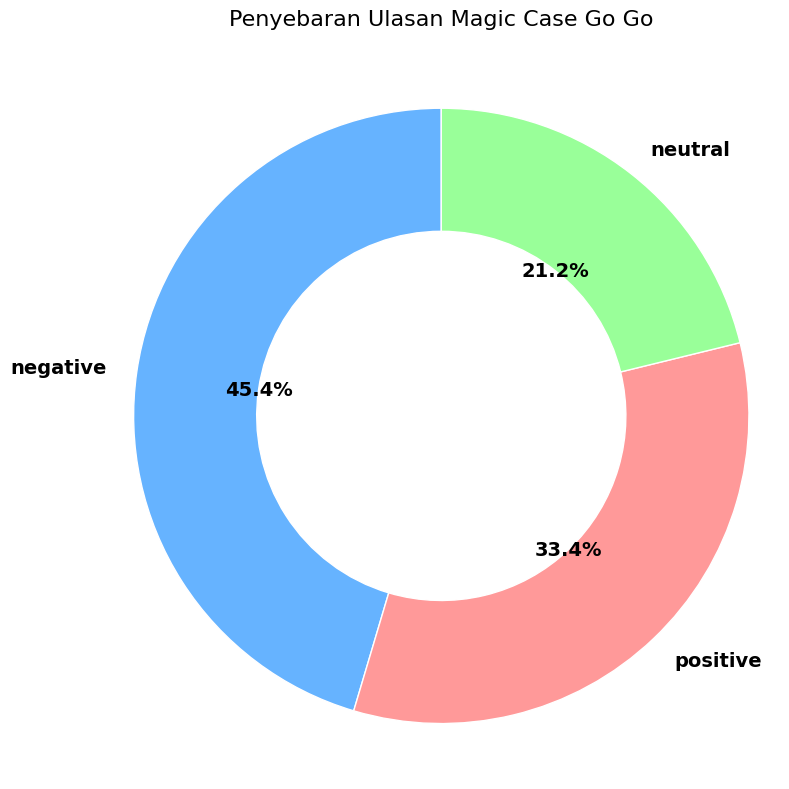

In [26]:
sentiment_counts = ready_df['label'].value_counts()
labels = sentiment_counts.index
sizes = sentiment_counts.values

# buat gambar dan sumbu
fig, ax = plt.subplots(figsize=(8, 8))

colors = ['#66b3ff','#ff9999','#99ff99'] # Biru, Merah Muda, Hijau

# buat Donut Chart
ax.pie(x=sizes,
       labels=labels,
       autopct='%1.1f%%',
       startangle=90,
       colors=colors,
       textprops={'fontsize': 14, 'weight': 'bold'},
       wedgeprops=dict(width=0.4, edgecolor='w'))

# lingkaran di tengah
center_circle = plt.Circle((0,0), 0.50, fc='white')
fig.gca().add_artist(center_circle)

# judul
ax.set_title('Penyebaran Ulasan Magic Case Go Go', fontsize=16, pad=20)
ax.axis('equal')
plt.tight_layout()
plt.show()

In [27]:
pd.set_option('display.max_colwidth', 3000)

positive_sentiments = ready_df.loc[
    ready_df['label'] == 'positive',          # Filter baris
    ['text_akhir', 'label', 'text_stopword']  # Pilih kolom
].reset_index(drop=True)                      # Reset index

positive_sentiments.index += 1

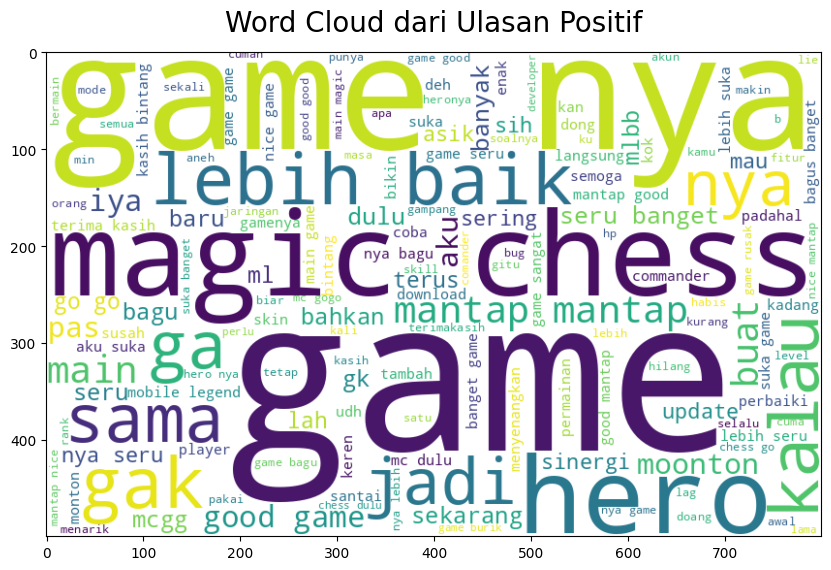

In [28]:
# gabungkan semua list kata
all_words_list = positive_sentiments['text_stopword'].sum()

# ubah list besar tersebut menjadi satu string tunggal
list_words = ' '.join(all_words_list)

# buat objek WordCloud
wordcloud = WordCloud(
    width=800,
    height=500,
    background_color='white',
    colormap='viridis',
    max_words=150,
    contour_width=1,
    contour_color='steelblue',
    min_font_size=10
).generate(list_words)

# buat plot
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title('Word Cloud dari Ulasan Positif', fontsize=20, pad=15)

# tampilkan
ax.imshow(wordcloud, interpolation='bilinear')

In [29]:
pd.set_option('display.max_colwidth', 3000)

negative_sentiments = ready_df.loc[
    ready_df['label'] == 'negative',          # Filter baris
    ['text_akhir', 'label', 'text_stopword']  # Pilih kolom
].reset_index(drop=True)                      # reset index

negative_sentiments.index += 1

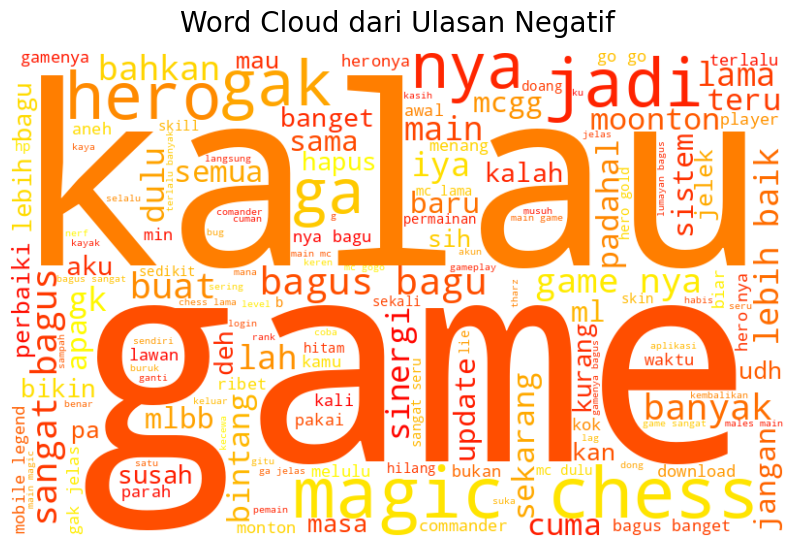

In [30]:
# gabungkan semua list kata
all_words_list = negative_sentiments['text_stopword'].sum()

# ubah list kata menjadi satu string tunggal
list_words = ' '.join(all_words_list)

# buat objek WordCloud
wordcloud = WordCloud(
    width=800,
    height=500,
    background_color='white',
    colormap='autumn',
    max_words=150,
    contour_width=1,
    contour_color='firebrick',
    min_font_size=10
).generate(list_words)

# buat plot
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title('Word Cloud dari Ulasan Negatif', fontsize=20, pad=15)

# buat WordCloud
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')

# tampilkan
plt.show()

In [31]:
pd.set_option('display.max_colwidth', 3000)

neutral_sentiments = ready_df.loc[
    ready_df['label'] == 'neutral',           # Filter baris
    ['text_akhir', 'label', 'text_stopword']  # Pilih kolom
].reset_index(drop=True)                      # reset index

neutral_sentiments.index += 1

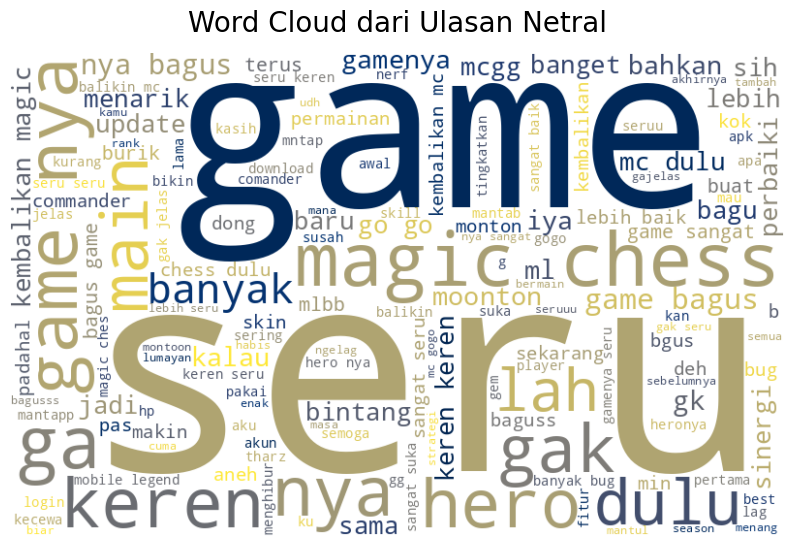

In [32]:
# gabungkan semua list kata
all_words_list = neutral_sentiments['text_stopword'].sum()

# ubah list kata menjadi satu string tunggal
list_words = ' '.join(all_words_list)

# buat objek WordCloud
wordcloud = WordCloud(
    width=800,
    height=500,
    background_color='white',
    colormap='cividis',
    max_words=150,
    contour_width=1,
    contour_color='grey',
    min_font_size=10
).generate(list_words)

# buat plot
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title('Word Cloud dari Ulasan Netral', fontsize=20, pad=15)

# tampilkan WordCloud
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')

# tampilkan
plt.show()

/tmp/ipython-input-33-1951227890.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)


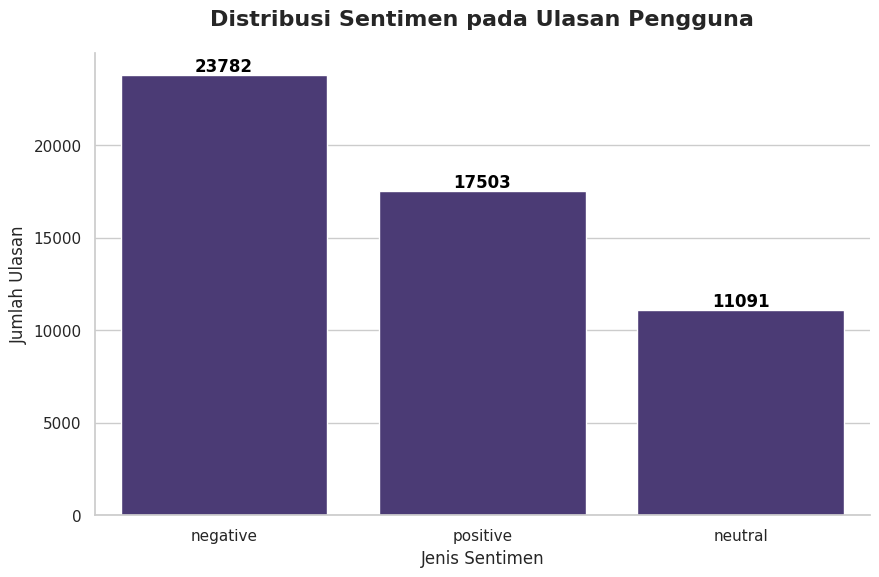

In [33]:
# atur tema visualisasi
sns.set_theme(style="whitegrid", palette="viridis")

# buat figure dan axes dalam satu baris
fig, ax = plt.subplots(figsize=(10, 6))

# buat plot
class_dist_plot = sns.countplot(ax=ax, x='label', data=ready_df)

# gunakan ax.bar_label
ax.bar_label(class_dist_plot.containers[0], fmt='%.0f', fontsize=12, color='black', weight='bold')

# judul dan label
ax.set_title('Distribusi Sentimen pada Ulasan Pengguna', fontsize=16, pad=20, weight='bold')
ax.set_xlabel('Jenis Sentimen', fontsize=12)
ax.set_ylabel('Jumlah Ulasan', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
sns.despine()

plt.show()

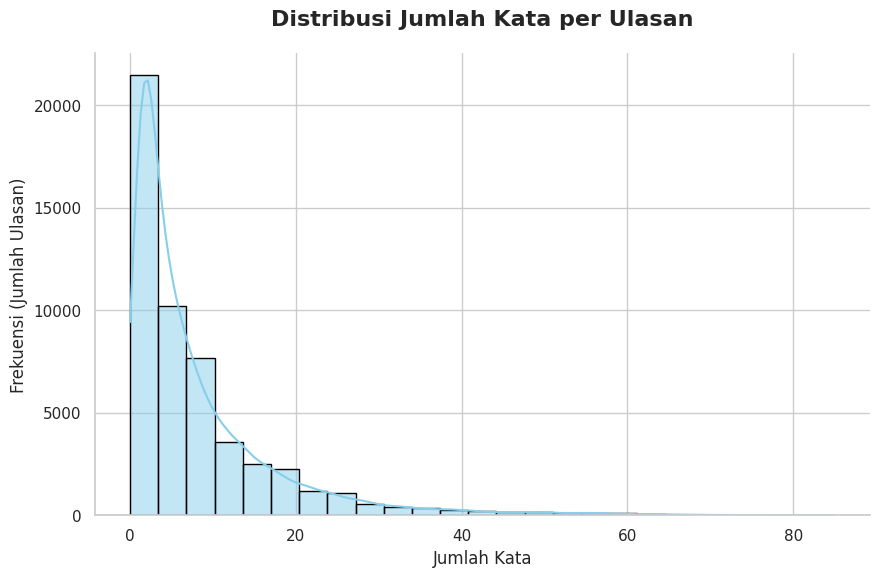

In [34]:
# hitung panjang teks
ready_df['text_length'] = ready_df['text_akhir'].str.split().str.len()

# buat figure dan axes
fig, ax = plt.subplots(figsize=(10, 6))

# tambahkan KDE plot dan warna untuk visualisasi
sns.histplot(ax=ax, data=ready_df, x='text_length', kde=True, bins=25, color='skyblue', edgecolor='black')

# judul dan label
ax.set_title('Distribusi Jumlah Kata per Ulasan', fontsize=16, pad=20, weight='bold')
ax.set_xlabel('Jumlah Kata', fontsize=12)
ax.set_ylabel('Frekuensi (Jumlah Ulasan)', fontsize=12)

sns.despine()
plt.show()

/tmp/ipython-input-35-2722089681.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(ax=ax, x='jumlah', y='kata', data=tfidf_df, palette='plasma')


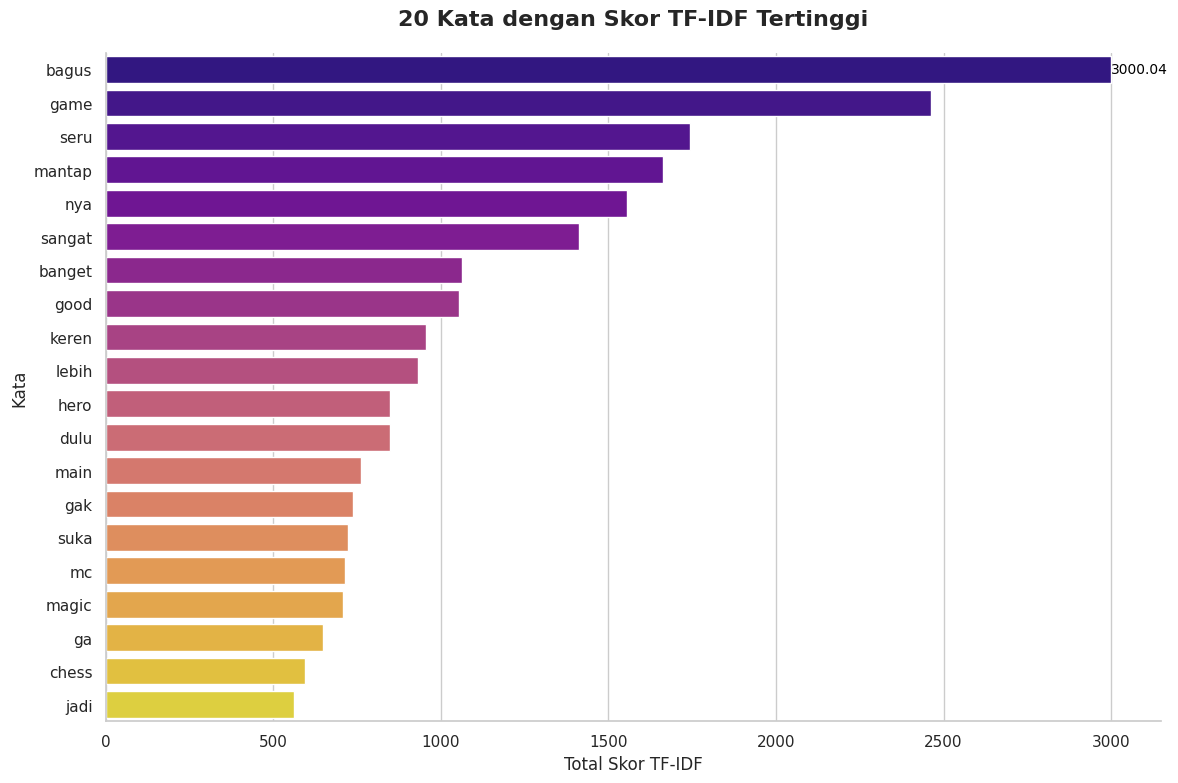

In [35]:
# ghitung skor TF-IDF tanpa mengubah ke dense array
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(ready_df['text_akhir'])

# jumlahkan skor TF-IDF untuk setiap kata di seluruh dokumen
sums = X.sum(axis=0)
sums_array = np.asarray(sums).ravel()

# buat DataFrame dari hasil penjumlahan skor
tfidf_df = pd.DataFrame({
    'kata': vectorizer.get_feature_names_out(),
    'jumlah': sums_array
})

# urutkan dan mengambil 20 kata teratas
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)

# buat figure dan axes
fig, ax = plt.subplots(figsize=(12, 8))

# menggunakan palet 'plasma' dan orientasi horizontal
barplot = sns.barplot(ax=ax, x='jumlah', y='kata', data=tfidf_df, palette='plasma')

# judul dan label
ax.set_title('20 Kata dengan Skor TF-IDF Tertinggi', fontsize=16, pad=20, weight='bold')
ax.set_xlabel('Total Skor TF-IDF', fontsize=12)
ax.set_ylabel('Kata', fontsize=12)

# tambahkan label skor pada setiap bar
ax.bar_label(barplot.containers[0], fmt='%.2f', fontsize=10, color='black')

sns.despine()
plt.tight_layout()
plt.show()

###**Ekstraksi Fitur**

**TF-IDF**

In [36]:
# fungsi untuk proses fitur TF-IDF
def create_tfidf_features(dataframe):

    X = dataframe['text_akhir']
    y = dataframe['label']
    tfidf = TfidfVectorizer(max_features=200,
                            min_df=100,
                            max_df=0.8)
    X_tfidf = tfidf.fit_transform(X)

    # konversi hasil ekstraksi fitur
    features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

    # kembalikan semua variabel
    return features_df, X, y, tfidf, X_tfidf

features_df, X, y, tfidf, X_tfidf = create_tfidf_features(ready_df)

# tampilkan hasil DataFrame
features_df

,adil,aku,akun,ampas,aneh,apa,apk,aplikasi,asik,awal,...,terlalu,terus,tharz,tiba,tolol,udh,up,update,versi,waktu
0,0.0,0.0,0.0,0.0,0.0,0.109802,0.0,0.0,0.0,0.0,...,0.551191,0.109533,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.314266
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.272076
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.182175,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.185423,0.0,0.0,0.0,0.0,...,0.186160,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52371,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
52372,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
52373,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
52374,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000


**Bag of Words**

In [37]:
# fungsi untuk mengolah bag of words
def create_bow_dataframe(data_input):
    vectorizer = CountVectorizer()
    X_bow_vec = vectorizer.fit_transform(data_input)
    df_bow = pd.DataFrame(X_bow_vec.toarray(), columns=vectorizer.get_feature_names_out())

    # kembalikan semua variabel
    return df_bow, vectorizer, X_bow_vec

# untuk mempertahankan nama variabel yang sama.
df_bow, vectorizer, X_bow_vec = create_bow_dataframe(X)

# cetak hasilnya
print(df_bow)

       __  ____________________________________  \
0       0                                     0   
1       0                                     0   
2       0                                     0   
3       0                                     0   
4       0                                     0   
...    ..                                   ...   
52371   0                                     0   
52372   0                                     0   
52373   0                                     0   
52374   0                                     0   
52375   0                                     0   

       _____________________________________________  _lebih  _magic  \
0                                                  0       0       0   
1                                                  0       0       0   
2                                                  0       0       0   
3                                                  0       0       0   
4                          

###**Pemodelan**

**1. Random Forest with BoW**

In [38]:
def train_and_evaluate_classifier(model, X_features, y_labels, test_size=0.3, random_state=42):

    # pisahkan data
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=test_size, random_state=random_state)

    # latih model
    model.fit(X_train, y_train)

    # buat prediksi
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # evaluasi akurasi
    accuracy_train = accuracy_score(y_pred_train, y_train)
    accuracy_test = accuracy_score(y_pred_test, y_test)

    # tampilkan akurasi
    model_name = type(model).__name__
    print(f"{model_name} - accuracy_train: {accuracy_train*100:.2f} %")
    print(f"{model_name} - accuracy_test: {accuracy_test*100:.2f} %")

    return X_train, X_test, y_train, y_test, model, y_pred_train, y_pred_test, accuracy_train, accuracy_test

# buat objek model
random_forest_bow = RandomForestClassifier()

# panggil fungsi
(Xbow_train, Xbow_test, ybow_train, ybow_test,
 random_forest_bow,
 y_pred_train_rf, y_pred_test_rf,
 accuracy_train_rf, accuracy_test_rf) = train_and_evaluate_classifier(random_forest_bow, X_bow_vec, y)

RandomForestClassifier - accuracy_train: 100.00 %
RandomForestClassifier - accuracy_test: 86.28 %


**2. Random Forest with TF-IDF**

In [39]:
def train_evaluate_on_sparse(model, X_features, y_labels, test_size=0.2, random_state=42):
    # pisahkan data
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=test_size, random_state=random_state)

    # konversi data fitur ke dense array
    X_train_array = X_train.toarray()
    X_test_array = X_test.toarray()

    # latih model
    model.fit(X_train_array, y_train)

    # buat prediksi
    y_pred_train = model.predict(X_train_array)
    y_pred_test = model.predict(X_test_array)

    # evaluasi akurasi
    accuracy_train = accuracy_score(y_pred_train, y_train)
    accuracy_test = accuracy_score(y_pred_test, y_test)

    # tampilkan akurasi
    model_name = type(model).__name__
    print(f"{model_name} - accuracy_train: {accuracy_train*100:.2f} %")
    print(f"{model_name} - accuracy_test: {accuracy_test*100:.2f} %")

    # kembalikan semua variabel yang dibuat
    return X_train, X_test, y_train, y_test, model, y_pred_train, y_pred_test, accuracy_train, accuracy_test

# buat objek model terlebih dahulu
random_forest = RandomForestClassifier()

# panggil fungsi dan outputnya
(Xt_train, Xt_test, yt_train, yt_test,
 random_forest,
 y_pred_train_rf, y_pred_test_rf,
 accuracy_train_rf, accuracy_test_rf) = train_evaluate_on_sparse(random_forest, X_tfidf, y)

RandomForestClassifier - accuracy_train: 94.25 %
RandomForestClassifier - accuracy_test: 81.27 %


**3. Logistic Regression with TF-IDF**

In [40]:
def fit_predict_and_evaluate(model, X_train, y_train, X_test, y_test):
    # latih model
    model.fit(X_train.toarray(), y_train)

    # buat prediksi
    y_pred_train = model.predict(X_train.toarray())
    y_pred_test = model.predict(X_test.toarray())

    # evaluasi akurasi
    accuracy_train = accuracy_score(y_pred_train, y_train)
    accuracy_test = accuracy_score(y_pred_test, y_test)

    # tampilkan akurasi
    model_name = type(model).__name__
    print(f"{model_name} - accuracy_train: {accuracy_train*100:.2f} %")
    print(f"{model_name} - accuracy_test: {accuracy_test*100:.2f} %")

    return model, y_pred_train, y_pred_test, accuracy_train, accuracy_test

# buat objek model terlebih dahulu
logistic_regression = LogisticRegression()

# panggil fungsi dengan data yang sudah di split
(logistic_regression,
 y_pred_train_lr, y_pred_test_lr,
 accuracy_train_lr, accuracy_test_lr) = fit_predict_and_evaluate(
                                            model=logistic_regression,
                                            X_train=Xbow_train,
                                            y_train=ybow_train,
                                            X_test=Xbow_test,
                                            y_test=ybow_test
                                         )

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression - accuracy_train: 96.36 %
LogisticRegression - accuracy_test: 91.29 %


####**Inference**

In [41]:
# fungsi pipeline
def run_prediction_pipeline(texts_to_predict, tfidf_vec, bow_vec, rf_bow_model, rf_tfidf_model, lr_model):
    def preprocess_text(text):
        text = text.lower()
        return text

    # preprocessing teks input
    clean_samples = [preprocess_text(text) for text in texts_to_predict]

    # transformasi fitur
    tfidf_features = tfidf_vec.transform(clean_samples)
    bow_features = bow_vec.transform(clean_samples)

    # melakukan prediksi dengan masing-masing model
    rfw_prediction = rf_bow_model.predict(bow_features)
    rft_prediction = rf_tfidf_model.predict(tfidf_features)
    lr_prediction = lr_model.predict(bow_features)

    # cetak hasil
    print("Prediksi Sentimen (Random Forest with BoW):", rfw_prediction)
    print("Prediksi Sentimen (Random Forest TFIDF):", rft_prediction)
    print("Prediksi Sentimen (Logistic Regression TFIDF):", lr_prediction)

    return clean_samples, tfidf_features, bow_features, rfw_prediction, rft_prediction, lr_prediction

# teks baru yang akan diprediksi
sample_text = ["Aplikasi busuk, banyak bug","Biasa aja","Wahhh Keren Banget"]

# panggil fungsi pipeline dan menangkap semua outputnya
(new_clean_sample,
 new_tfidf_vec, new_bow_vec,
 RFW_predict, RFT_predict, LR_predict) = run_prediction_pipeline(
                                            texts_to_predict=sample_text,
                                            tfidf_vec=tfidf,
                                            bow_vec=vectorizer,
                                            rf_bow_model=random_forest_bow,
                                            rf_tfidf_model=random_forest,
                                            lr_model=logistic_regression
                                         )

Prediksi Sentimen (Random Forest with BoW): ['negative' 'negative' 'positive']
Prediksi Sentimen (Random Forest TFIDF): ['negative' 'negative' 'positive']
Prediksi Sentimen (Logistic Regression TFIDF): ['negative' 'negative' 'positive']
